In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.utils.data import dataloader
import utils
from arguments import parse_args
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from IPython.display import clear_output as clear
import wandb


%matplotlib inline
%load_ext autoreload
%autoreload 2

class LossLogger(object):
    def __init__(self, decay):
        self.loss_history = []
        self.loss = 0
        self.decay = decay
        
    def push(self, loss):
        self.loss_history.append(loss)
        self.loss *= self.decay
        self.loss += loss * (1-self.decay)
        
    def loss(self):
        return self.loss
    
    def flush(self):
        self.loss = 0

    def history(self):
        return self.loss_history
    
    
logger = LossLogger(0.8)

In [2]:
args = parse_args(["--alg", "VDSR", "--point_num", "10000", "--description", "psnr+ssim+10000pts+set5", "--lr", "1e-3", "--epoch", "20", '--data_root', 'data/set5'])

In [3]:
wandb.init(project="cg-vdsr-set5-10000", entity="purewhite2019")
wandb.config = {
  "learning_rate": 1e-3,
  "epochs": 20,
  "point_num" : 10000
}
# Training Preparation
utils.set_seed_everywhere(args.seed)

device = torch.device('cuda:0' if args.device == 'gpu' and torch.cuda.is_available() else 'cpu')
print(device)

train_dataset = utils.TrainDataset(args)
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)

loss_function = nn.MSELoss()

# loss_function = lambda img_gt, img_pred : -utils.psnr(img_gt, img_pred) - utils.ssim(img_gt, img_pred)

model = utils.make_model(args).to(device)
model = model.float()

optimizer = optim.RAdam(params=model.parameters(),lr=args.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10000,gamma = 0.4)

e = 0

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: purewhite2019 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


cuda:0


In [4]:
print(len(train_loader))

97


In [5]:
import torch.nn.functional as F
# Start training
lr_list = []
model.train()
wandb.watch(model)

for _ in range(args.epoch):
    # train_loader = tqdm.tqdm(train_loader)
    for idx, img_pair in enumerate(train_loader):
        
        img_hr = img_pair['hr'].to(device)
        img_lr = img_pair['lr'].to(device)
        
        if args.alg == 'CNF':
            img_predict, loss = model(x_hr=img_hr, xlr=img_lr)
        else:
            img_predict = model(img_lr)
            # loss = loss_function(img_hr, img_predict)
            mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_predict.reshape((img_hr.shape[0], -1)))
            psnr = utils.psnr(img_hr, img_predict)
            ssim = utils.ssim(img_hr, img_predict)
            loss = -psnr/300 - ssim + mse
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        with torch.no_grad():
            lr_psnr = utils.psnr(img_hr, img_lr)
            lr_ssim = utils.ssim(img_hr, img_lr)
            lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
            
        wandb.log({"psnr improvement": (psnr-lr_psnr)*100/lr_psnr})
        wandb.log({"ssim improvement": (ssim-lr_ssim)*100/lr_ssim})
        wandb.log({"mse improvement": (lr_mse-mse)*100/lr_mse})
        wandb.log({"psnr": psnr})
        wandb.log({"ssim": ssim})
        wandb.log({"mse": mse})
        wandb.log({"loss": loss})
        
        logger.push(loss.item())
        # if idx % 10 == 0:
        #     clear()
        #     # utils.show_gt_and_pred(img_hr=img_hr[0].permute(1,2,0).cpu(), img_lr=img_lr[0].permute(1,2,0).cpu(), pred_hr=img_predict[0].permute(1,2,0).detach().cpu(), figsize=(30, 30))
        # # train_loader.set_description(f"epoch: {e} | idx: {idx} | loss: {logger.loss}")
        #     print(f"epoch: {e} | idx: {idx}/{len(train_loader)} | loss: {logger.loss}")
        #     print(f"prediction: psnr: {psnr} | ssim: {ssim} | mse: {mse}")
        #     print(f"delaunay: psnr: {lr_psnr} | ssim: {lr_ssim} | lr_mse: {lr_mse}")
        #     print(f"relative improvement: {(psnr-lr_psnr)*100/lr_psnr}% | ssim: {(ssim-lr_ssim)*100/lr_ssim}% | mse: {(lr_mse-mse)*100/lr_mse}%")


    utils.save_model(model, e, args)
    e += 1

/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Untyped global name 'draw_delaunay_blur': Cannot determine Numba type of <class 'function'>

File "sampling/triangulation_blur.py", line 151:
def DelaunayTriangulationBlur(img, point_num=1000, method="center"):
    <source elided>
    # Draw delaunay triangles
    draw_delaunay_blur( img, subdiv, method ) 
    ^

  @nb.jit()
/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "sampling/triangulation_blur.py", line 127:
def DelaunayTriangulationBlur(img, point_num=1000, method="center"):
    <

In [8]:
import torch.nn.functional as F

utils.set_seed_everywhere(args.seed)
device = torch.device('cuda:0' if args.device == 'gpu' and torch.cuda.is_available() else 'cpu')

model = utils.make_model(args).to(device)
model = model.float()
save_path = os.path.join("/home/purewhite/workspace/cg-proj/NUG-DLSS/logs/VDSR_psnr+ssim+10000pts+set5_19.pth")
if not torch.cuda.is_available():
    model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load(save_path))
        
test_dataset = utils.TestDataset(args)
test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)
model.eval()

loop = tqdm.tqdm(test_loader)

tot_mse = 0
tot_psnr = 0
tot_ssim = 0

tot_lr_mse = 0
tot_lr_psnr = 0
tot_lr_ssim = 0

with torch.no_grad():
    for idx, img_pair in enumerate(loop):
        
        img_hr = img_pair['hr'].to(device)
        img_lr = img_pair['lr'].to(device)
        
        if args.alg == 'CNF':
            img_predict, loss = model(x_hr=img_hr, xlr=img_lr)
        else:
            img_predict = model(img_lr)
            # loss = loss_function(img_hr, img_predict)
            mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_predict.reshape((img_hr.shape[0], -1)))
            psnr = utils.psnr(img_hr, img_predict)
            ssim = utils.ssim(img_hr, img_predict)
            loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loop.set_description(f"relative improvement: {(psnr-lr_psnr)*100/lr_psnr}% | ssim: {(ssim-lr_ssim)*100/lr_ssim}% | mse: {(lr_mse-mse)*100/lr_mse}%")
        # if idx % 10 == 0:
        #     clear()
        #     # utils.show_gt_and_pred(img_hr=img_hr[0].permute(1,2,0).cpu(), img_lr=img_lr[0].permute(1,2,0).cpu(), pred_hr=img_predict[0].permute(1,2,0).detach().cpu(), figsize=(30, 30))
        # # train_loader.set_description(f"epoch: {e} | idx: {idx} | loss: {logger.loss}")
        #     print(f"epoch: {e} | idx: {idx}/{len(train_loader)} | loss: {logger.loss}")
        #     print(f"prediction: psnr: {psnr} | ssim: {ssim} | mse: {mse}")
        #     print(f"delaunay: psnr: {lr_psnr} | ssim: {lr_ssim} | lr_mse: {lr_mse}")
        #     print(f"relative improvement: {(psnr-lr_psnr)*100/lr_psnr}% | ssim: {(ssim-lr_ssim)*100/lr_ssim}% | mse: {(lr_mse-mse)*100/lr_mse}%")

print(f"Total relative improvement: {(tot_psnr-tot_lr_psnr)*100/tot_lr_psnr}% | ssim: {(tot_ssim-tot_lr_ssim)*100/tot_lr_ssim}% | mse: {(tot_lr_mse-tot_mse)*100/tot_lr_mse}%")

relative improvement: 3.028794050216675% | ssim: 18.798425674438477% | mse: 37.29236602783203%:  49%|████▉     | 40/82 [01:39<04:30,  6.45s/it]  

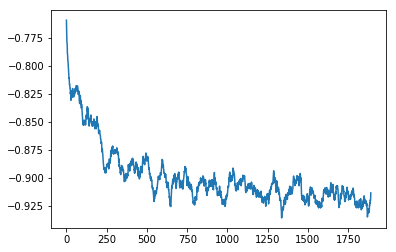

In [6]:
# todo: equivalent to 130,000 batches or about 10 epochs.

loss_history = logger.history()
kernel = np.ones((50))/50

smooth_history = np.convolve(loss_history, kernel, mode='valid')
# plt.plot(lr_list)
plt.plot(smooth_history)
plt.show()
# print((lr_list))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])
torch.Size([1, 3, 256, 256])
torch.Size([256, 256, 3]) torch.Size([256, 256, 3]) torch.Size([256, 256, 3])


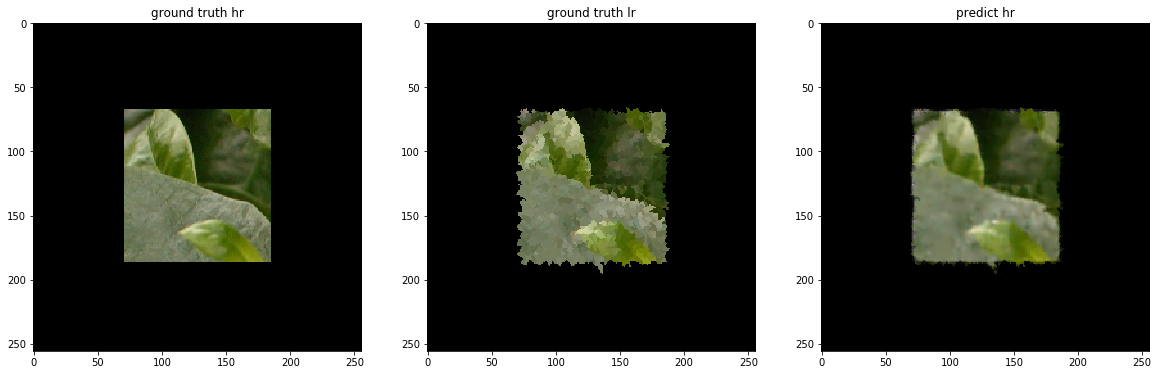

In [7]:
import random

img_pair = train_dataset[random.randint(0, len(train_dataset)-1)]
model.eval()
img_hr, img_lr = img_pair
img_hr = img_pair['hr']
img_lr = img_pair['lr']
print(img_lr.shape)
img_pred = model(img_lr.unsqueeze(0).permute(0, 3,1,2).to(device))
print(img_pred.shape)

# img_hr = img_hr.permute(1,2,0).cpu()
# img_lr = img_lr.permute(1,2,0).cpu()
img_pred = img_pred.squeeze(0).permute(1,2,0).detach().cpu()

print(img_hr.shape, img_lr.shape, img_pred.shape)
utils.show_gt_and_pred(img_lr=img_lr, img_hr=img_hr, pred_hr=img_pred, figsize=(20, 20))

In [8]:
import os

save_path = os.path.join(args.log_dir, args.alg+'_'+args.description+'_'+'0-epoch-14143-iter'+'.pth')
torch.save(model.state_dict(), save_path)

In [9]:
img = train_dataset[0]['hr'].numpy()
print(type(img), img.shape)
utils.DelaunayTriangulationBlur(img, 10000).shape

<class 'numpy.ndarray'> (256, 256, 3)


/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Untyped global name 'draw_delaunay_blur': Cannot determine Numba type of <class 'function'>

File "sampling/triangulation_blur.py", line 151:
def DelaunayTriangulationBlur(img, point_num=1000, method="center"):
    <source elided>
    # Draw delaunay triangles
    draw_delaunay_blur( img, subdiv, method ) 
    ^

  @nb.jit()
/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "sampling/triangulation_blur.py", line 127:
def DelaunayTriangulationBlur(img, point_num=1000, method="center"):
    <

(256, 256, 3)

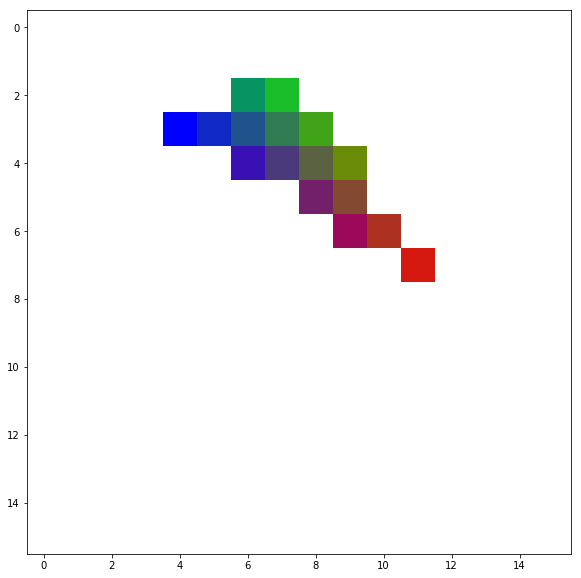

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
# create black background image
result = np.ones((16,16,3), dtype=np.uint8) * 255

# Specify (x,y) triangle vertices
a = (3,4)
b = (1,7)
c = (8,12)

# Specify colors
red = np.array([0,0,255])
green = np.array([0,255,0])
blue = np.array([255,0,0])

# Make array of vertices
# ax bx cx
# ay by cy
#  1  1  1
triArr = np.asarray([a[0],b[0],c[0], a[1],b[1],c[1], 1,1,1]).reshape((3, 3))

# Get bounding box of the triangle
xleft = min(a[0], b[0], c[0])
xright = max(a[0], b[0], c[0])
ytop = min(a[1], b[1], c[1])
ybottom = max(a[1], b[1], c[1])

# Build np arrays of coordinates of the bounding box
xs = range(xleft, xright)
ys = range(ytop, ybottom)
xv, yv = np.meshgrid(xs, ys)
xv = xv.flatten()
yv = yv.flatten()

# Compute all least-squares /
p = np.array([xv, yv, [1] * len(xv)])
alphas, betas, gammas = np.linalg.lstsq(triArr, p, rcond=-1)[0]

# Apply mask for pixels within the triangle only
mask = (alphas > 0) & (betas > 0) & (gammas > 0)
alphas_m = alphas[mask]
betas_m = betas[mask]
gammas_m = gammas[mask]
xv_m = xv[mask]
yv_m = yv[mask]

def mul(a, b) :
    # Multiply two vectors into a matrix
    return np.asmatrix(b).T @ np.asmatrix(a)

# Compute and assign colors
colors = mul(red, alphas_m) + mul(green, betas_m) + mul(blue, gammas_m)
result[xv_m, yv_m] = colors

# show results
# cv2.imshow('result', result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.figure(1, figsize=(10, 10))
plt.imshow(result)
plt.show()

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


(1080, 1920, 3)


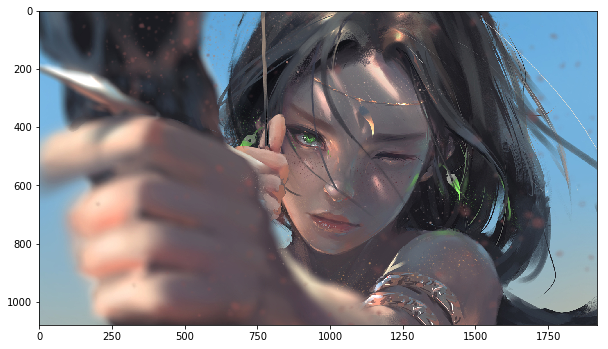

In [12]:
from PIL import Image
img = Image.open("/home/purewhite/workspace/cg-proj/NUG-DLSS/imgs/img_origin.jpeg")
img = np.array(img)
plt.figure(1, figsize=(10, 10))
plt.imshow(img)
print(img.shape)
plt.show()


1080 1920


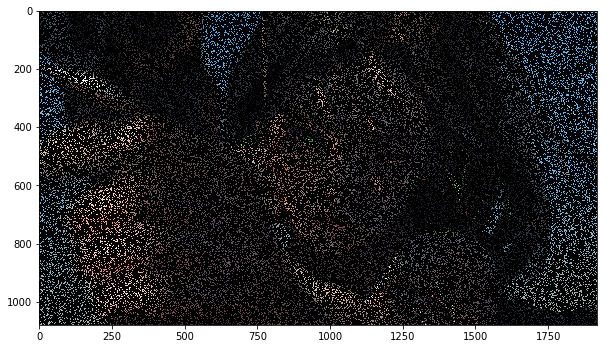

In [13]:
img_mask = np.zeros_like(img)

points = set()

# 随机采点
width = img.shape[0]
height = img.shape[1]
print(width, height)
while len(points) < 414720: #* 20% information preserved
# for i in range(1000):
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)
    points.add((y,x))


for p in points:
    img_mask[p[1]][p[0]] = 1

img_corrupted = img * img_mask

plt.figure(1, figsize=(10, 10))
plt.imshow(img_corrupted)
plt.show()

In [14]:
def downsample2(img):
    img_mask = (img != 0).any(axis = 2).astype(np.int32)
    print(img_mask.shape)
    img_downsampled = np.zeros((img.shape[0]//2, img.shape[1]//2, 3), dtype=np.int32)
    for i in range(img_downsampled.shape[0]):
        for j in range(img_downsampled.shape[1]):
            num_valid = img_mask[2*i][2*j] + img_mask[2*i+1][2*j] + img_mask[2*i][2*j+1] + img_mask[2*i+1][2*j+1]
            color_sum =  img[2*i][2*j] + img[2*i+1][2*j] + img[2*i][2*j+1] + img[2*i+1][2*j+1]
            if (num_valid != 0):
                img_downsampled[i][j] = np.floor_divide(color_sum, num_valid)
    return img_downsampled

(1080, 1920)
(540, 960, 3)


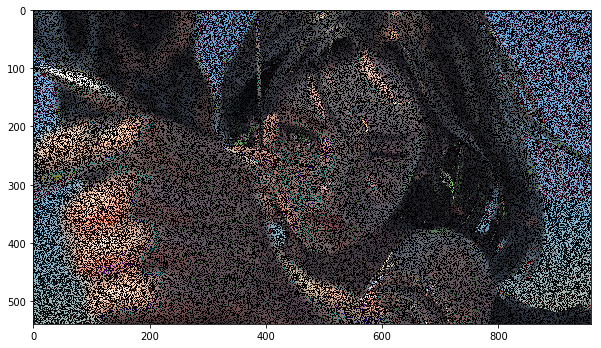

In [15]:
img_corrupted_downsampled = downsample2(img_corrupted)
print(img_corrupted_downsampled.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(img_corrupted_downsampled)
plt.show()


(540, 960)
(270, 480, 3)


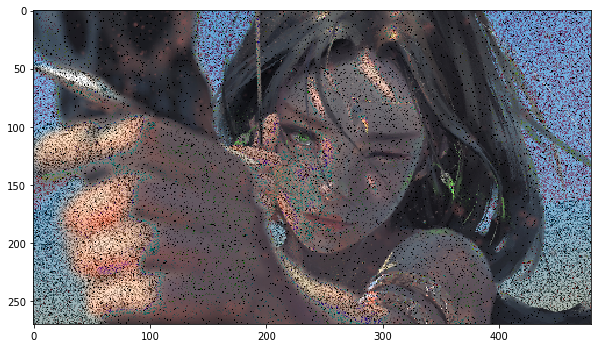

In [16]:
img_corrupted_downsampled2 = downsample2(img_corrupted_downsampled)
print(img_corrupted_downsampled2.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(img_corrupted_downsampled2)
plt.show()

(270, 480)
(135, 240, 3)


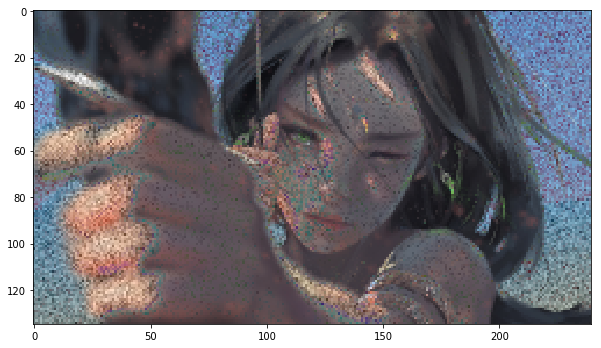

In [17]:
img_corrupted_downsampled3 = downsample2(img_corrupted_downsampled2)
print(img_corrupted_downsampled3.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(img_corrupted_downsampled3)
plt.show()

(135, 240)
(67, 120, 3)


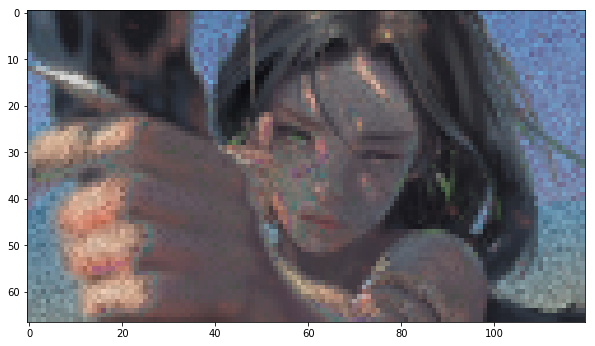

In [18]:
img_corrupted_downsampled4 = downsample2(img_corrupted_downsampled3)
print(img_corrupted_downsampled4.shape)
plt.figure(1, figsize=(10, 10))
plt.imshow(img_corrupted_downsampled4)
plt.show()